Libraries imported successfully!
Dataset loaded successfully!
Dataset shape: (30000, 24)
Dataset columns: ['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score', 'No. of Defaults', 'Has Active Credit Card', 'Property ID', 'Property Age', 'Property Type', 'Property Location', 'Co-Applicant', 'Property Price', 'Loan Sanction Amount (USD)']

First 5 rows:
  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614

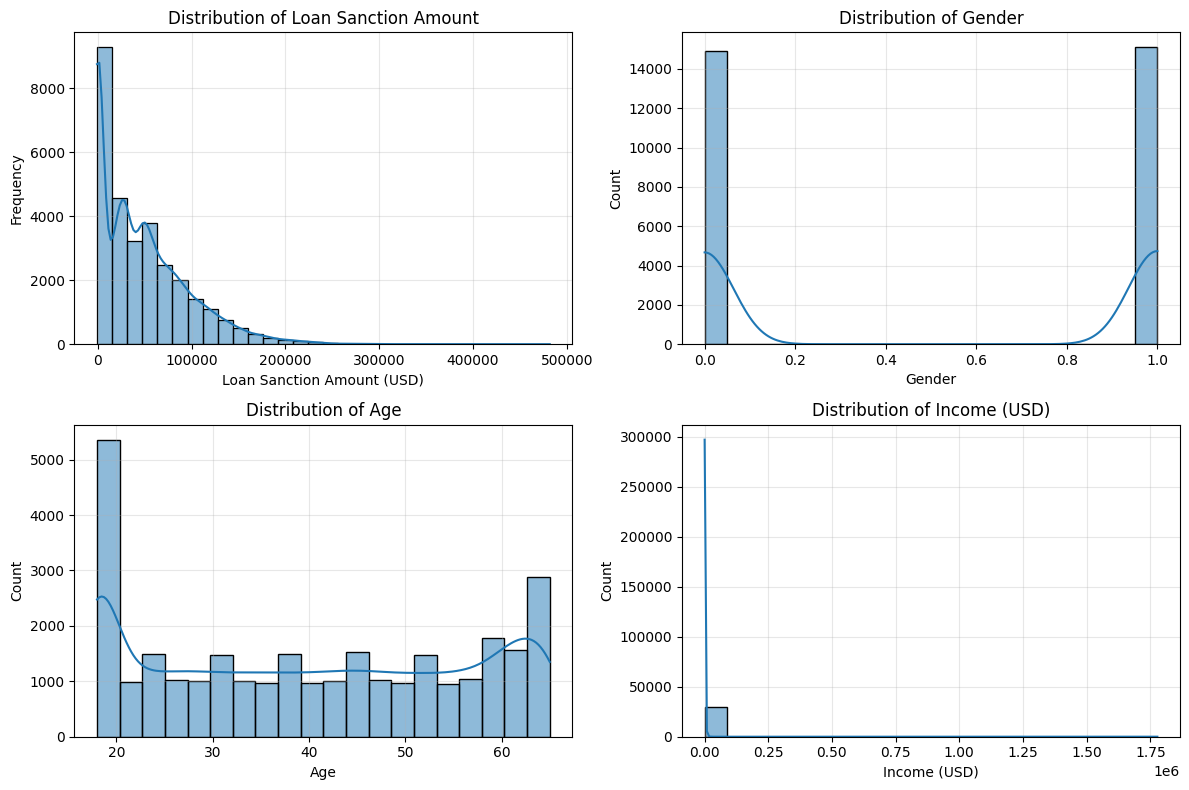

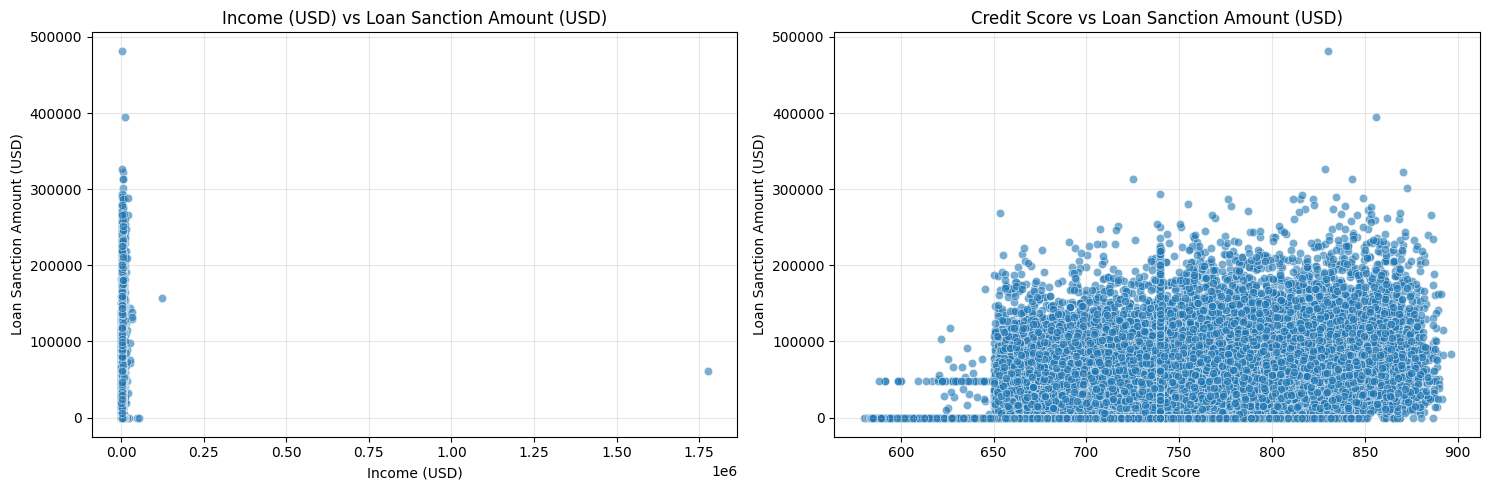

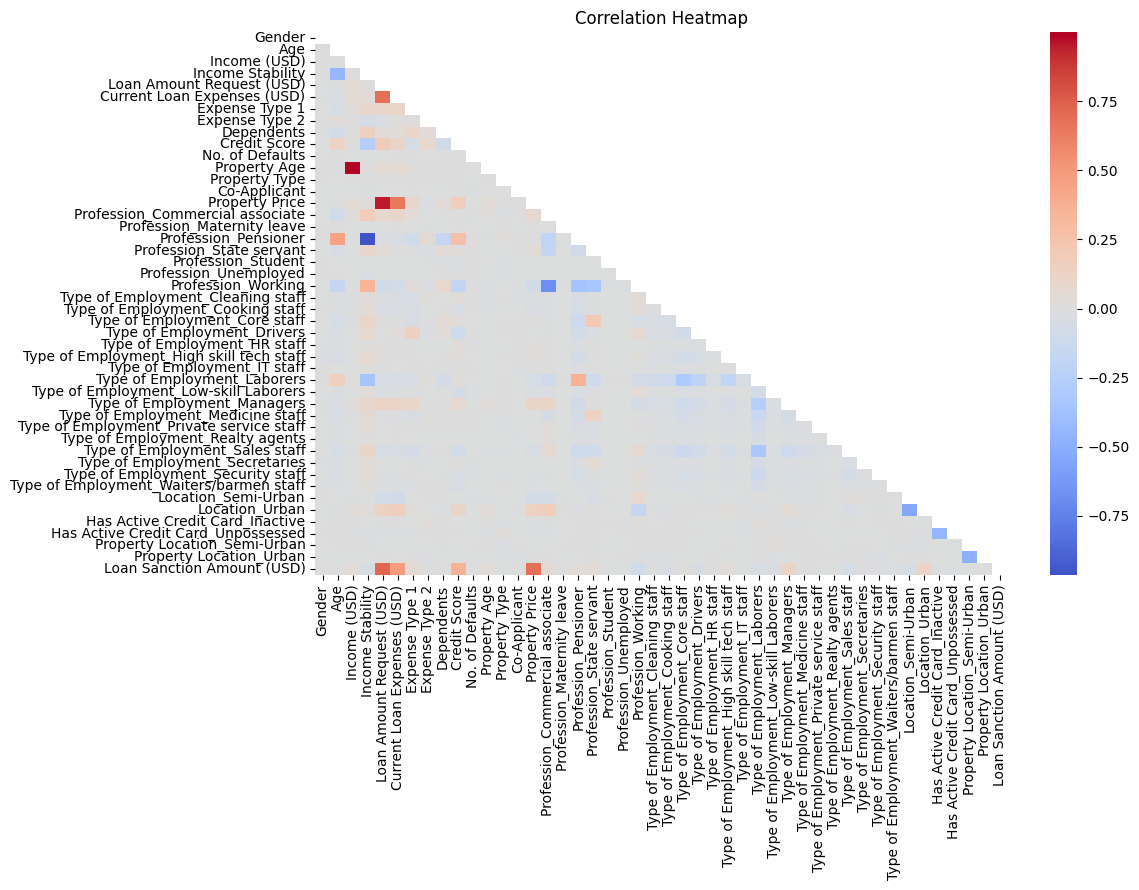

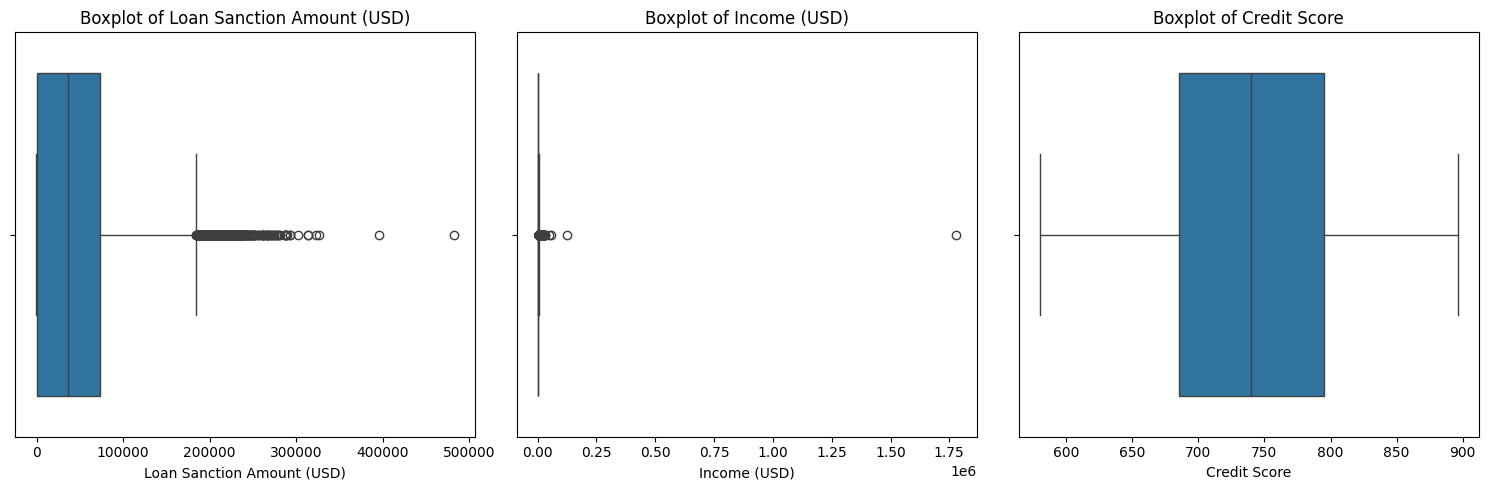

Scaling features...
Features scaled successfully!
Splitting dataset...
Training set size: 21000
Validation set size: 4500
Test set size: 4500
Training Linear Regression Model...
Linear Regression Evaluation:

--- Validation Results ---
MAE  : 21558.1258
MSE  : 946388207.0774
RMSE : 30763.4232
R²   : 0.5819

--- Test Results ---
MAE  : 21967.5256
MSE  : 992766452.7216
RMSE : 31508.1966
R²   : 0.5595

Performing K-Fold Cross-Validation (K=5) for Linear Regression...
Fold 1 — MAE: 21751.4881, MSE: 1000187741.7488, RMSE: 31625.7449, R²: 0.5649
Fold 2 — MAE: 21853.8051, MSE: 979222213.1624, RMSE: 31292.5265, R²: 0.5690
Fold 3 — MAE: 22386.7539, MSE: 1064073204.6620, RMSE: 32620.1350, R²: 0.5403
Fold 4 — MAE: 21760.0608, MSE: 995920512.7585, RMSE: 31558.2083, R²: 0.5764
Fold 5 — MAE: 21023.4924, MSE: 880308985.9435, RMSE: 29670.0014, R²: 0.6100

Table 1: Cross-Validation Results (K = 5)
   Fold        MAE             MSE       RMSE  R2_Score
 Fold 1 21751.4881 1000187741.7488 31625.7449    0

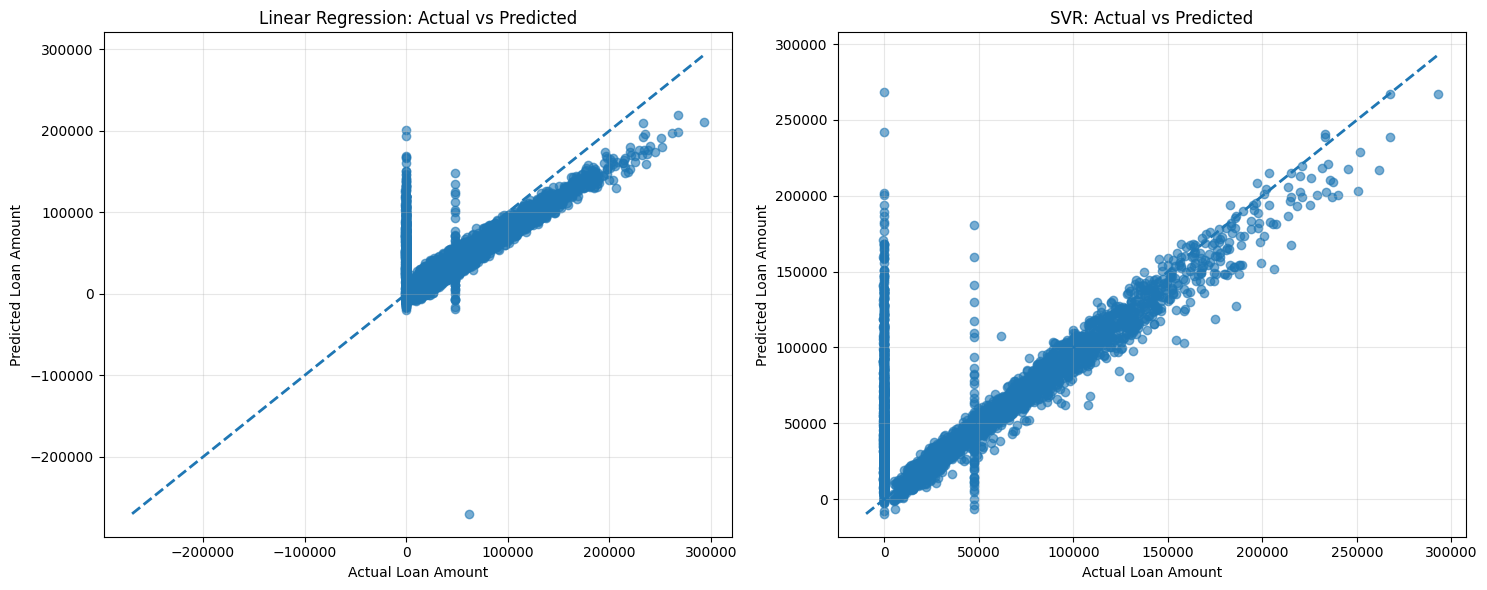

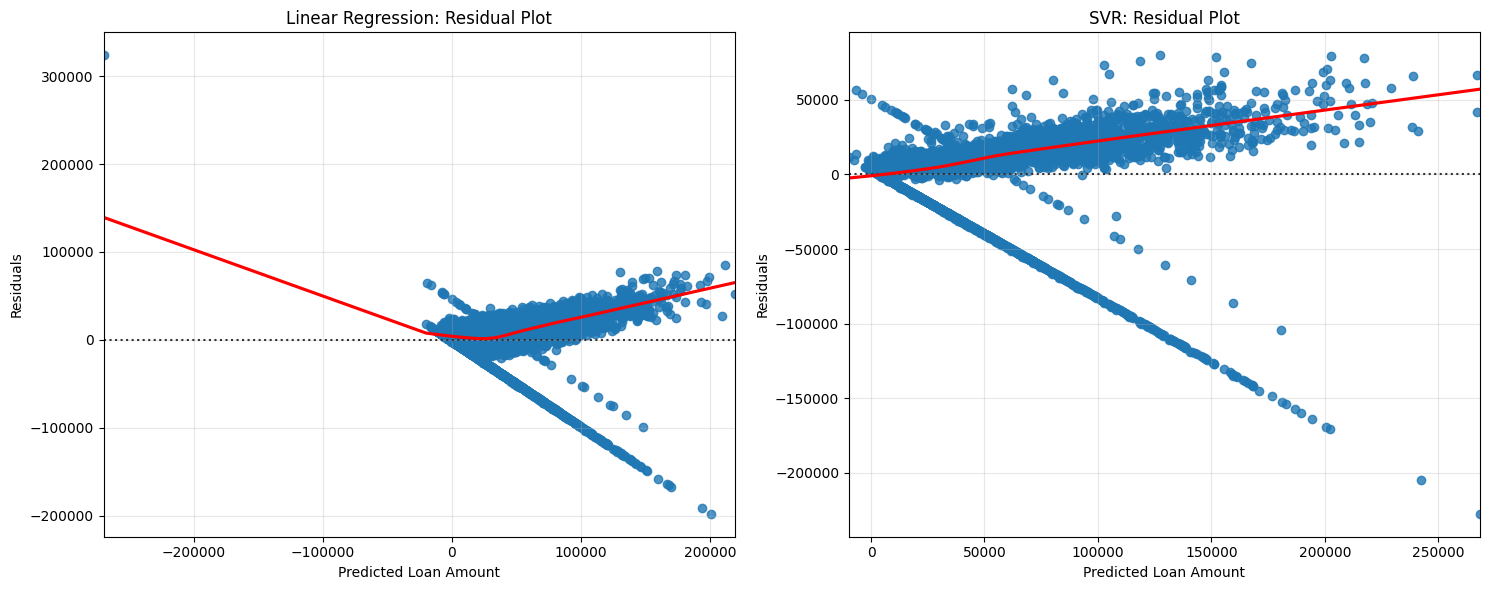

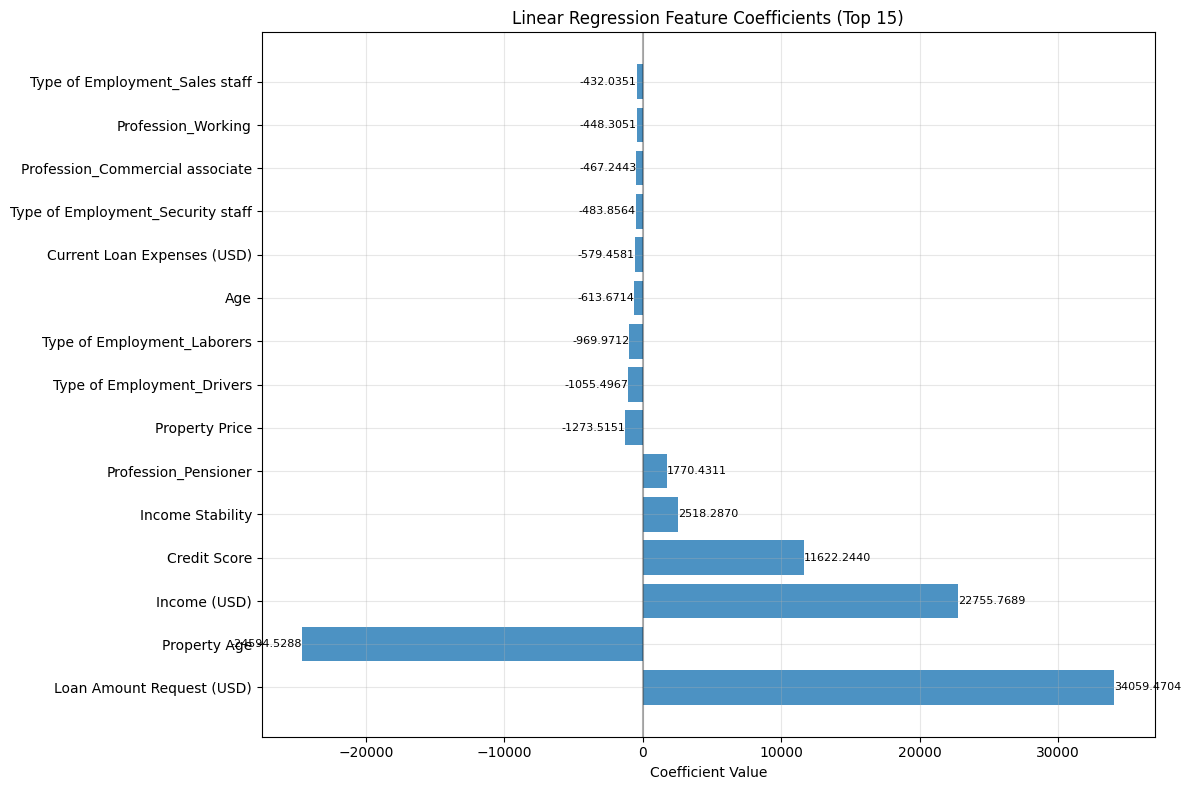

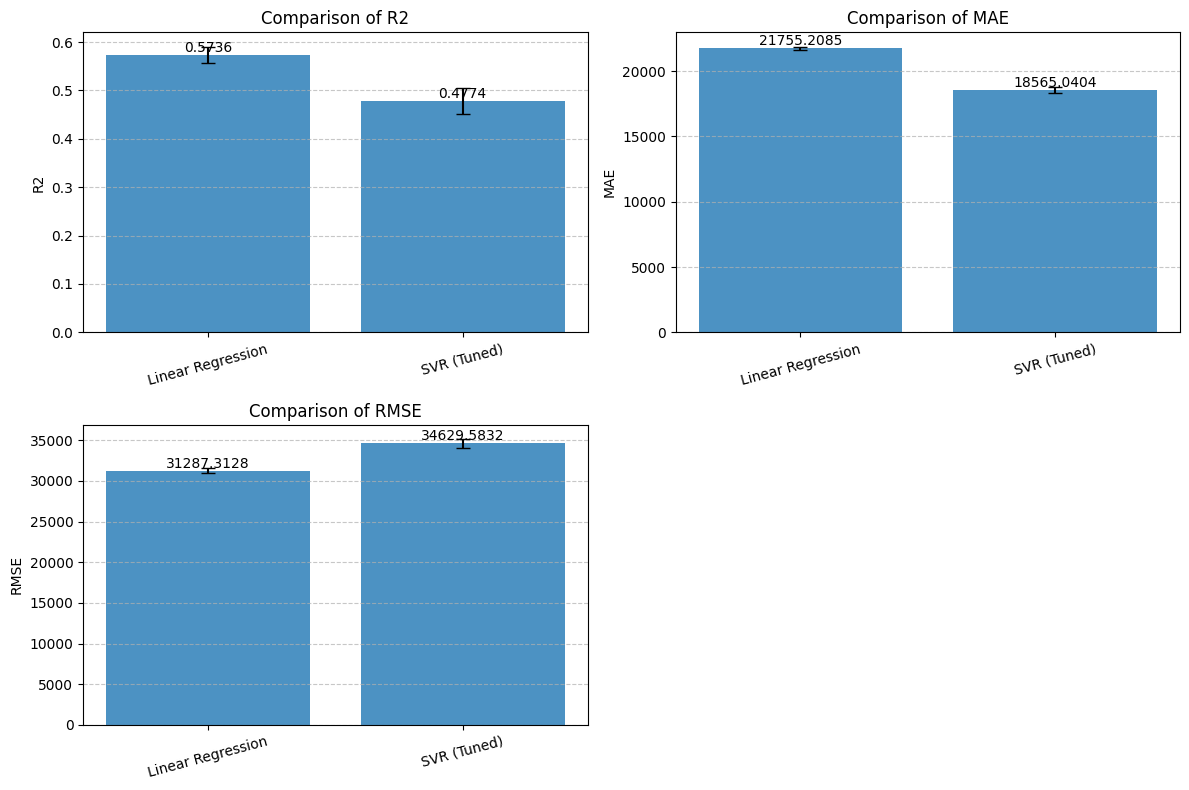

Linear Regression Adjusted R²: 0.5550
SVR Adjusted R²: 0.4673

RESULTS SUMMARY

Table 2: Summary of Results for Loan Amount Prediction
                               Description                Linear Regression Result                                     SVR Result
        Dataset Size (after preprocessing)              30000 samples, 45 features                     30000 samples, 45 features
                    Train/Test Split Ratio     70% Train, 15% Validation, 15% Test            70% Train, 15% Validation, 15% Test
              Features Used for Prediction                    45 features (scaled)                           45 features (scaled)
                                Model Used                       Linear Regression                            SVR (linear kernel)
           Cross-Validation Used? (Yes/No)                                     Yes                Yes (for hyperparameter tuning)
                       Number of Folds (K)                                       5   

In [2]:
# ====================================================================
# Sri Sivasubramaniya Nadar College of Engineering, Chennai
# Experiment 2: Loan Amount Prediction using Linear Regression
# Student: [Your Name]
# Roll Number: [Your Roll Number]
# ====================================================================

# ----------------------
# 1. IMPORTS AND LIBRARIES
# ----------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

RANDOM_STATE = 42

print("Libraries imported successfully!")
print("=" * 60)

# ----------------------
# 2. LOAD DATASET
# ----------------------
DATA_PATH = "train.csv"  # <-- change if needed
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Could not find '{DATA_PATH}'. Please set DATA_PATH correctly.")

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print("=" * 60)

# ----------------------
# 3. DATA PREPROCESSING
# ----------------------
print("Starting data preprocessing...")

# Drop obviously non-predictive IDs if present
columns_to_drop = ['Customer ID', 'Name', 'Property ID', 'Loan_ID', 'ID']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
if existing_columns_to_drop:
    df.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"Dropped columns: {existing_columns_to_drop}")

# Check for missing values
print(f"\nMissing values before handling:")
print(df.isnull().sum())

# Handle missing values
# For categorical columns - fill with mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode(dropna=True)[0], inplace=True)

# For numerical columns - fill with mean
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

print(f"\nMissing values after handling:")
print(df.isnull().sum())

# ----------------------
# 4. TARGET SELECTION & ENCODING
# ----------------------
# Identify target column robustly
preferred_target_names = [
    'Loan Sanction Amount (USD)', 'LoanAmount', 'Loan_Amount', 'loan_amount',
    'SanctionedAmount', 'AmountSanctioned'
]
target_col = None
for cand in preferred_target_names:
    if cand in df.columns:
        target_col = cand
        break

# If not found, heuristically pick a numeric column with both 'loan' and 'amount' in the name
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.str.lower()
    candidates = [c for c in df.columns if ('loan' in c.lower() and 'amount' in c.lower())]
    if candidates:
        target_col = candidates[0]
    else:
        # As a last resort, pick the last numeric column (often targets are at the end)
        if len(numeric_cols) == 0:
            raise ValueError("No numeric columns found to use as target.")
        target_col = df.columns[df.columns.get_indexer([df.columns[list(numeric_cols).index(numeric_cols[-1])]])[0]]

print(f"Using target column: {target_col}")

# Separate features/target
y = df[target_col]
X = df.drop(columns=[target_col])

# Encode categoricals
print("\nEncoding categorical variables...")
label_encoder = LabelEncoder()

# Binary encoding: exactly 2 unique categories
obj_cols = X.select_dtypes(include='object').columns.tolist()
binary_cols = [col for col in obj_cols if X[col].nunique(dropna=True) == 2]
for col in binary_cols:
    X[col] = label_encoder.fit_transform(X[col].astype(str))
    print(f"Binary encoded: {col}")

# One-hot encoding for multi-class categoricals
multi_cols = [col for col in obj_cols if col not in binary_cols]
if multi_cols:
    X = pd.get_dummies(X, columns=multi_cols, drop_first=True)
    print(f"One-hot encoded: {multi_cols}")

print(f"Final dataset shape after preprocessing: {pd.concat([X, y], axis=1).shape}")
print("=" * 60)

# ----------------------
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------
print("Performing Exploratory Data Analysis...")

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("Target statistics:")
print(y.describe())

# ----------------------
# 6. REQUIRED VISUALIZATIONS
# ----------------------
# 1) Distribution plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(y, kde=True, bins=30)
plt.title("Distribution of Loan Sanction Amount")
plt.xlabel(target_col)
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Pick up to 3 numeric features safely
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
top_num_cols = num_cols[:3]

for i, col in enumerate(top_num_cols, start=2):
    plt.subplot(2, 2, i)
    sns.histplot(X[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2) Scatter plots
plt.figure(figsize=(15, 5))

def find_like(col_keywords, fallback_idx=0):
    for col in X.columns:
        if any(k in col.lower() for k in col_keywords):
            if np.issubdtype(X[col].dtype, np.number):
                return col
    return (num_cols[fallback_idx] if len(num_cols) > fallback_idx else X.columns[min(fallback_idx, X.shape[1]-1)])

income_col = find_like(['income'])
credit_col = find_like(['credit', 'score'], fallback_idx=1)

plt.subplot(1, 2, 1)
sns.scatterplot(x=X[income_col], y=y, alpha=0.6)
plt.title(f"{income_col} vs {target_col}")
plt.xlabel(income_col); plt.ylabel(target_col); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X[credit_col], y=y, alpha=0.6)
plt.title(f"{credit_col} vs {target_col}")
plt.xlabel(credit_col); plt.ylabel(target_col); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3) Correlation Heatmap (numeric only)
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)
plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
# Annotate only if not too wide (<= 25 cols)
annot_flag = corr.shape[0] <= 25
sns.heatmap(corr, mask=mask, annot=annot_flag, fmt='.2f', cmap='coolwarm', center=0, square=False, cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 4) Boxplots (guarded)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=y)
plt.title(f"Boxplot of {target_col}")
plt.xlabel(target_col)

plt.subplot(1, 3, 2)
sns.boxplot(x=X[income_col])
plt.title(f"Boxplot of {income_col}")
plt.xlabel(income_col)

plt.subplot(1, 3, 3)
sns.boxplot(x=X[credit_col])
plt.title(f"Boxplot of {credit_col}")
plt.xlabel(credit_col)

plt.tight_layout()
plt.show()

print("=" * 60)

# ----------------------
# 7. FEATURE SCALING
# ----------------------
print("Scaling features...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
print("Features scaled successfully!")

# ----------------------
# 8. TRAIN-VALIDATION-TEST SPLIT
# ----------------------
print("Splitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("=" * 60)

# ----------------------
# 9. LINEAR REGRESSION MODEL
# ----------------------
print("Training Linear Regression Model...")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

def evaluate_model(model, X_data, y_true, name="Set"):
    y_pred = model.predict(X_data)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {name} Results ---")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    return mae, mse, rmse, r2

print("Linear Regression Evaluation:")
lr_val_results = evaluate_model(lr_model, X_val, y_val, "Validation")
lr_test_results = evaluate_model(lr_model, X_test, y_test, "Test")

# ----------------------
# 10. K-FOLD CROSS-VALIDATION FOR LINEAR REGRESSION
# ----------------------
print("\n" + "=" * 60)
print("Performing K-Fold Cross-Validation (K=5) for Linear Regression...")

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
lr_mae_list, lr_mse_list, lr_rmse_list, lr_r2_list = [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), start=1):
    X_tr, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_tr, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    lr_cv_model = LinearRegression()
    lr_cv_model.fit(X_tr, y_tr)
    y_pred_cv = lr_cv_model.predict(X_val_cv)

    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_cv, y_pred_cv)

    lr_mae_list.append(mae)
    lr_mse_list.append(mse)
    lr_rmse_list.append(rmse)
    lr_r2_list.append(r2)

    print(f"Fold {fold} — MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

cv_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)] + ['Average'],
    'MAE': lr_mae_list + [np.mean(lr_mae_list)],
    'MSE': lr_mse_list + [np.mean(lr_mse_list)],
    'RMSE': lr_rmse_list + [np.mean(lr_rmse_list)],
    'R2_Score': lr_r2_list + [np.mean(lr_r2_list)]
})

print("\nTable 1: Cross-Validation Results (K = 5)")
print("=" * 80)
print(cv_results.to_string(index=False, float_format='%.4f'))

# ----------------------
# 11. HYPERPARAMETER TUNING WITH SVR (OPTIMIZED)
# ----------------------
print("\n" + "=" * 60)
print("Performing Hyperparameter Tuning with SVR...")

# Reduced parameter grid for faster execution
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1],
    'gamma': ['scale', 0.01]
}

svr_model = SVR()
svr_search = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_grid_svr,
    n_iter=10,  # Reduced from 20
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0  # Reduced verbosity
)

print("Training SVR with hyperparameter tuning...")
svr_search.fit(X_train, y_train)

print(f"Best SVR Parameters: {svr_search.best_params_}")
print(f"Best Cross-Validation R² Score: {svr_search.best_score_:.4f}")

best_svr = svr_search.best_estimator_

print("\nSVR Evaluation:")
svr_val_results = evaluate_model(best_svr, X_val, y_val, "Validation")
svr_test_results = evaluate_model(best_svr, X_test, y_test, "Test")

# ----------------------
# 12. MODEL COMPARISON (OPTIMIZED)
# ----------------------
print("\n" + "=" * 60)
print("Comparing Linear Regression vs SVR...")

models = {
    'Linear Regression': lr_model,
    'SVR (Tuned)': best_svr
}

comparison_results = {}
# Use 3-fold CV for faster execution
for name, model in models.items():
    r2_scores = cross_val_score(model, X_scaled, y, cv=3, scoring='r2')
    neg_mse_scores = cross_val_score(model, X_scaled, y, cv=3, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_mse_scores)
    neg_mae_scores = cross_val_score(model, X_scaled, y, cv=3, scoring='neg_mean_absolute_error')
    mae_scores = -neg_mae_scores

    comparison_results[name] = {
        'R2_Mean': r2_scores.mean(),
        'R2_Std': r2_scores.std(),
        'RMSE_Mean': rmse_scores.mean(),
        'RMSE_Std': rmse_scores.std(),
        'MAE_Mean': mae_scores.mean(),
        'MAE_Std': mae_scores.std()
    }

comparison_df = pd.DataFrame(comparison_results).T
print("\nModel Comparison (Cross-Validation Results):")
print(comparison_df)

# ----------------------
# 13. VISUALIZATIONS
# ----------------------
# Actual vs Predicted
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
y_pred_lr = lr_model.predict(X_test)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
lims = [min(y_test.min(), y_pred_lr.min()), max(y_test.max(), y_pred_lr.max())]
plt.plot(lims, lims, '--', linewidth=2)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Loan Amount"); plt.ylabel("Predicted Loan Amount"); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
y_pred_svr = best_svr.predict(X_test)
lims = [min(y_test.min(), y_pred_svr.min()), max(y_test.max(), y_pred_svr.max())]
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot(lims, lims, '--', linewidth=2)
plt.title("SVR: Actual vs Predicted")
plt.xlabel("Actual Loan Amount"); plt.ylabel("Predicted Loan Amount"); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual plots
plt.figure(figsize=(15, 6))
residuals_lr = y_test - y_pred_lr
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred_lr, y=residuals_lr, lowess=True, line_kws={'color': 'red'})
plt.title("Linear Regression: Residual Plot")
plt.xlabel("Predicted Loan Amount"); plt.ylabel("Residuals"); plt.grid(True, alpha=0.3)

residuals_svr = y_test - y_pred_svr
plt.subplot(1, 2, 2)
sns.residplot(x=y_pred_svr, y=residuals_svr, lowess=True, line_kws={'color': 'red'})
plt.title("SVR: Residual Plot")
plt.xlabel("Predicted Loan Amount"); plt.ylabel("Residuals"); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Coefficients (LR)
coefficients = lr_model.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', key=np.abs, ascending=False)

plt.figure(figsize=(12, 8))
top_features = coef_df.head(15)
bars = plt.barh(top_features['Feature'], top_features['Coefficient'], alpha=0.8)
plt.title("Linear Regression Feature Coefficients (Top 15)")
plt.xlabel("Coefficient Value")
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.001 if width >= 0 else -0.001),
        bar.get_y() + bar.get_height()/2,
        f'{width:.4f}',
        ha='left' if width >= 0 else 'right',
        va='center',
        fontsize=8
    )
plt.tight_layout()
plt.show()

# Model Performance Comparison
plt.figure(figsize=(12, 8))
metrics = ['R2_Mean', 'MAE_Mean', 'RMSE_Mean']
model_names = list(comparison_results.keys())

for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    values = [comparison_results[m][metric] for m in model_names]
    stds = [comparison_results[m][metric.replace('Mean', 'Std')] for m in model_names]
    bars = plt.bar(model_names, values, yerr=stds, capsize=5, alpha=0.8)
    plt.title(f'Comparison of {metric.replace("_Mean", "")}')
    plt.ylabel(metric.replace("_Mean", ""))
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ----------------------
# 14. ADJUSTED R²
# ----------------------
def adjusted_r2_score(r2, n_samples, n_features):
    """Calculate adjusted R² score safely"""
    if n_samples - n_features - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

n_samples = X_test.shape[0]
n_features = X_test.shape[1]

lr_adj_r2 = adjusted_r2_score(lr_test_results[3], n_samples, n_features)
svr_adj_r2 = adjusted_r2_score(r2_score(y_test, y_pred_svr), n_samples, n_features)

print(f"Linear Regression Adjusted R²: {lr_adj_r2:.4f}" if not np.isnan(lr_adj_r2) else "Linear Regression Adjusted R²: N/A")
print(f"SVR Adjusted R²: {svr_adj_r2:.4f}" if not np.isnan(svr_adj_r2) else "SVR Adjusted R²: N/A")

# ----------------------
# 15. RESULTS SUMMARY TABLE (FIXED)
# ----------------------
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

most_influential_features = coef_df.head(3)['Feature'].tolist() if not coef_df.empty else []

residual_mean = float(np.mean(residuals_lr))
residual_std = float(np.std(residuals_lr))

train_r2 = r2_score(y_train, lr_model.predict(X_train))
test_r2 = lr_test_results[3]
overfitting_check = "Yes" if (train_r2 - test_r2) > 0.1 else "No"

# Calculate SVR metrics
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, y_pred_svr)

results_summary = {
    'Description': [
        'Dataset Size (after preprocessing)',
        'Train/Test Split Ratio',
        'Features Used for Prediction',
        'Model Used',
        'Cross-Validation Used? (Yes/No)',
        'Number of Folds (K)',
        'Reference to CV Results Table',
        'Mean Absolute Error (MAE) on Test Set',
        'Mean Squared Error (MSE) on Test Set',
        'Root Mean Squared Error (RMSE) on Test Set',
        'R² Score on Test Set',
        'Adjusted R² Score on Test Set',
        'Most Influential Feature(s)',
        'Observations from Residual Plot',
        'Interpretation of Predicted vs Actual Plot',
        'Any Overfitting or Underfitting Observed?',
        'Brief Justification'
    ],
    'Linear Regression Result': [
        f"{df.shape[0]} samples, {X.shape[1]} features",
        "70% Train, 15% Validation, 15% Test",
        f"{X.shape[1]} features (scaled)",
        "Linear Regression",
        "Yes",
        "5",
        "Table 1",
        f"{lr_test_results[0]:.4f}",
        f"{lr_test_results[1]:.4f}",
        f"{lr_test_results[2]:.4f}",
        f"{lr_test_results[3]:.4f}",
        f"{lr_adj_r2:.4f}" if not np.isnan(lr_adj_r2) else "N/A",
        ", ".join(most_influential_features[:2]) if most_influential_features else "N/A",
        f"Mean: {residual_mean:.4f}, Std: {residual_std:.4f}",
        f"Model explains {lr_test_results[3]*100:.1f}% of variance",
        overfitting_check,
        f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}"
    ],
    'SVR Result': [
        f"{df.shape[0]} samples, {X.shape[1]} features",
        "70% Train, 15% Validation, 15% Test",
        f"{X.shape[1]} features (scaled)",
        f"SVR ({svr_search.best_params_['kernel']} kernel)",
        "Yes (for hyperparameter tuning)",
        "3",
        "Hyperparameter tuning results",
        f"{svr_mae:.4f}",
        f"{svr_mse:.4f}",
        f"{svr_rmse:.4f}",
        f"{svr_r2:.4f}",
        f"{svr_adj_r2:.4f}" if not np.isnan(svr_adj_r2) else "N/A",
        "Feature importance not available for SVR",
        f"Mean: {float(np.mean(residuals_svr)):.4f}, Std: {float(np.std(residuals_svr)):.4f}",
        f"Model explains {svr_r2*100:.1f}% of variance",
        "N/A",
        "SVR uses regularization to prevent overfitting"
    ]
}

results_df = pd.DataFrame(results_summary)
print("\nTable 2: Summary of Results for Loan Amount Prediction")
print("=" * 120)
print(results_df.to_string(index=False))

# ----------------------
# 16. ADDITIONAL ANALYSIS
# ----------------------
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)
if not coef_df.empty:
    print("Top 10 Most Influential Features (Linear Regression):")
    print(coef_df.head(10).to_string(index=False, float_format='%.6f'))
else:
    print("No coefficients available (check that X has numeric columns).")

print(f"\nBest Performing Model: {'SVR' if svr_r2 > lr_test_results[3] else 'Linear Regression'}")
print(f"Linear Regression Test R²: {lr_test_results[3]:.4f}")
print(f"SVR Test R²: {svr_r2:.4f}")

# ----------------------
# 17. SAVE RESULTS (OPTIONAL)
# ----------------------
# cv_results.to_csv('cv_results.csv', index=False)
# results_df.to_csv('results_summary.csv', index=False)
# comparison_df.to_csv('model_comparison.csv')

print("\n" + "=" * 60)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("All required components have been implemented:")
print("✓ Data preprocessing and feature engineering")
print("✓ Linear Regression model training and evaluation")
print("✓ K-Fold Cross-Validation (K=5)")
print("✓ SVR with hyperparameter tuning")
print("✓ All required visualizations")
print("✓ Performance metrics (MAE, MSE, RMSE, R², Adjusted R²)")
print("✓ Results summary tables")
print("✓ Model comparison and analysis")
print("=" * 60)